# Brain Tumour Classification
***
## Table of Contents

1. [Introduction](#1-introduction)
1. [Device Agnostic Code](#2-device-agnostic-code)
1. [Loading Data](#3-loading-data)
1. [Preparing Data](#preparing-data)
    - [Data Transformation](#data-transformation)
    - [Preparing DataLoaders](#preparing-dataloaders)
1. [Understanding Data](#5-understanding-data)
1. [Transfer Learning](#6-transfer-learning)
    - [ResNet-18](#resnet-18)
    - [EfficientNet B0](#efficientnet-b0)
1. [Evaluation Metrics](#7-evaluation-metrics)
1. [Loss Function](#8-loss-function)
    - [Cross-Entropy Loss](#cross-entropy-loss)
1. [Optimiser](#9-optimiser)
1. [Training and Evaluation](#10-training-and-evaluation)
    - [Training Steps](#training-steps)
    - [Validation Steps](#validation-steps)
    - [Model Training and Evaluation Pipeline](#model-training-and-evaluation-pipeline)
1. [Results](#11-results)
    - [Overall Performance](#overall-performance)
    - [Classifications](#classifications)
    - [Missclassifications](#missclassifications)
    - [Confusion Matrix](#confusion-matrix)
    - [Observations](#observations)
1. [Vision Transformer (ViT)](#12-vision-transformer-vit)
    - [Converting Image Data for ViT](#converting-image-data-for-vit)
    - [Loading Pre-Trained Model](#loading-pre-trained-model)
    - [Training Arguments](#training-arguments)
    - [Evaluation Metrics for ViT](#evaluation-metrics-for-vit)
    - [Fine-Tuning Transformer Model](#fine-tuning-transformer-model)
    - [Predictions with Fine-Tuned Model](#predictions-with-fine-tuned-model)
1. [References](#13-references)
***

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from numpy.typing import NDArray
from torchvision import datasets, transforms, models
from torchinfo import summary
from torchmetrics import Accuracy, F1Score
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, Subset, Dataset

## 1. Introduction
Building machine learning models from scratch typically requires large amounts of data and substantial training time. In a production environment, it is often a good practice to use transfer learning, which involves using pre-trained models to address related tasks on new datasets. This approach significantly reduces training time and computational resources while often improving performance, especially when data availability is limited.

The objective of this project is to fine-tune and compare the performance of several pre-trained neural network models from PyTorch and Hugging Face for building a brain tumour classifier using MRI images. Specifically, we will fine-tune two widely adopted convolutional neural network (CNN) architectures, ResNet-18 and EfficientNet B0, alongside one of the base Vision Transformer (ViT) models available from Hugging Face. These models have demonstrated strong performance in various medical imaging tasks, including brain tumour detection and classification, and provide diverse architectural perspectives to evaluate in this domain.

## 2. Device Agnostic Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, `cuda` is used instead of `mps`.

In [2]:
# DEVICE = torch.device(device="cuda" if torch.cuda.is_available() else "cpu") # For Windows
DEVICE = torch.device(
    device="mps" if torch.backends.mps.is_available() else "cpu"
)  # For MacOS
DEVICE

device(type='mps')

## 3. Loading Data
Retrieved from [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

In [3]:
data_path = Path("_datasets/brain_mri")

if data_path.is_dir():
    print(f"{data_path} directory exists.")
else:
    print(f"{data_path} directory NOT FOUND!")

_datasets/brain_mri directory exists.


In [4]:
def walk_through_dir(dir_path: str) -> None:
    """
    Print the number of directories and image files in each subdirectory of a given directory.

    Args:
        dir_path: Path to the root directory to walk through.
    """
    for (
        directory_path,
        directory_names,
        file_names,
    ) in os.walk(dir_path):
        print(
            f"{len(directory_names)} directories and {len(file_names)} images found in {directory_path}"
        )

In [5]:
walk_through_dir(data_path)

2 directories and 0 images found in _datasets/brain_mri
4 directories and 0 images found in _datasets/brain_mri/Training
0 directories and 1457 images found in _datasets/brain_mri/Training/pituitary
0 directories and 1595 images found in _datasets/brain_mri/Training/notumor
0 directories and 1321 images found in _datasets/brain_mri/Training/glioma
0 directories and 1339 images found in _datasets/brain_mri/Training/meningioma
4 directories and 0 images found in _datasets/brain_mri/Testing
0 directories and 300 images found in _datasets/brain_mri/Testing/pituitary
0 directories and 405 images found in _datasets/brain_mri/Testing/notumor
0 directories and 300 images found in _datasets/brain_mri/Testing/glioma
0 directories and 306 images found in _datasets/brain_mri/Testing/meningioma


## 4. Preparing Data
### Data Transformation
For transfer learning using pretrained models in PyTorch, it is a common and effective practice to normalise the dataset using the standard mean and standard deviation values of the ImageNet dataset, on which many pretrained models were originally trained. This ensures that the input data distribution matches the distribution expected by the pretrained model, leading to better convergence and improved performance during fine-tuning.

[Reference - PyTorch Forums](https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670)

In addition to normalisation, various data augmentation techniques (such as random flips and random rotations) are applied to increase data diversity and improve the model's generalisation capability.

In [6]:
IMAGE_SIZE = 224
IMAGE_NET_MEANS = [0.485, 0.456, 0.406]
IMAGE_NET_STDS = [0.229, 0.224, 0.225]

train_transform = transforms.Compose(
    transforms=[
        transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=IMAGE_NET_MEANS,
            std=IMAGE_NET_STDS,
        ),
    ]
)

test_transform = transforms.Compose(
    transforms=[
        transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=IMAGE_NET_MEANS,
            std=IMAGE_NET_STDS,
        ),
    ]
)

### Preparing DataLoaders
The downloaded dataset contains only training and testing subsets; therefore, I split the original test subset into separate validation and test datasets in a 50:50 ratio.

In [7]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = "_datasets/brain_mri/Training"
TEST_DIR = "_datasets/brain_mri/Testing"
BATCH_SIZE = 16

train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
subset = datasets.ImageFolder(root=TEST_DIR, transform=test_transform)

# Get all indices
indices = list(range(len(subset)))

# Stratified split based on targets
train_idx, test_idx = train_test_split(
    indices, test_size=0.5, stratify=subset.targets, random_state=42
)

# Create proper Subset datasets
val_dataset = Subset(dataset=subset, indices=train_idx)
test_dataset = Subset(dataset=subset, indices=test_idx)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [8]:
print(f"Batch size: {BATCH_SIZE}")
print(f"- train_dataset: {len(train_dataset)} -> train_loader: {len(train_loader)}")
print(f"- val_dataset: {len(val_dataset)} -> val_loader: {len(val_loader)}")
print(f"- test_dataset: {len(test_dataset)} -> test_loader: {len(test_loader)}")


Batch size: 16
- train_dataset: 5712 -> train_loader: 357
- val_dataset: 655 -> val_loader: 41
- test_dataset: 656 -> test_loader: 41


In [9]:
print(f"Classes: {train_dataset.classes}")
print(f"Classes with indices: {train_dataset.class_to_idx}")

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Classes with indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## 5. Understanding Data

In [10]:
def show_images(
    dataset: Dataset, class_names: list[str], num_images: int | None = 9
) -> None:
    """
    Display a grid of images from a dataset with their corresponding class names as titles.

    Args:
        dataset: Dataset (image, label). Images assumed to be tensors.
        class_names: List of class names indexed by label.
        num_images: Number of images to display. Defaults to 9.

    Prints:
        A matplotlib plot grid of images with titles.
    """
    plt.figure(figsize=(9, 9))
    cols, rows = 3, 3
    indices = random.sample(population=range(len(dataset)), k=num_images)
    for i, index in enumerate(indices):
        image, label = dataset[index]
        image = image.numpy().transpose((1, 2, 0))  # Convert from CHW to HWC
        mean = np.array(IMAGE_NET_MEANS)
        std = np.array(IMAGE_NET_STDS)
        image = std * image + mean
        image = np.clip(image, 0, 1)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.tight_layout()
        plt.axis("off")
    plt.show()

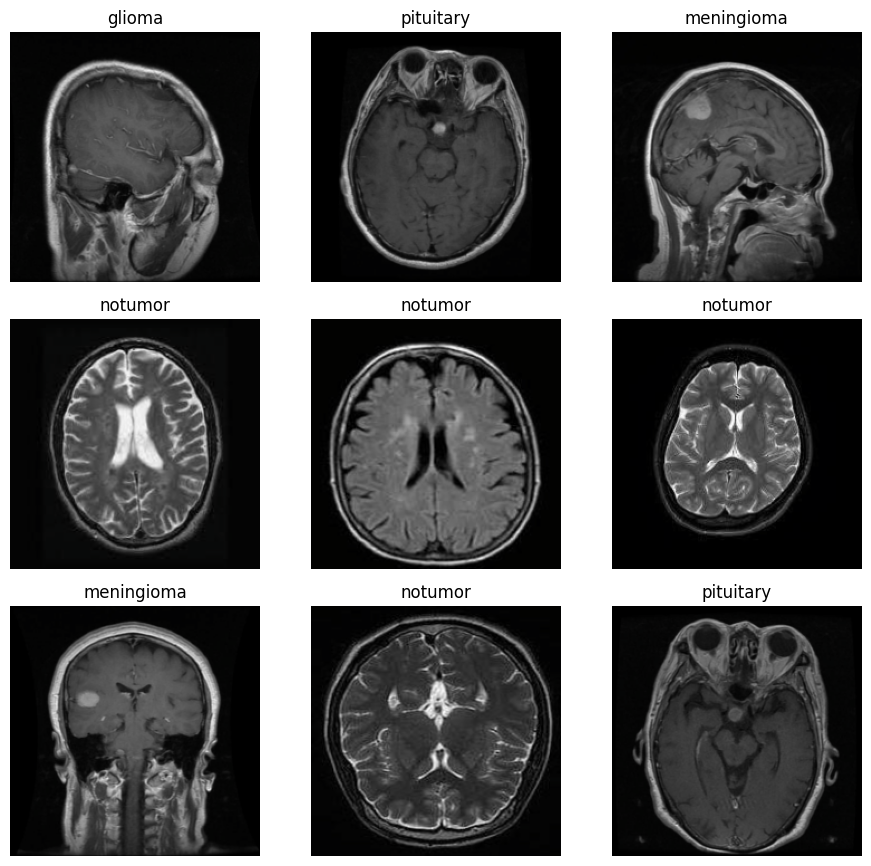

In [11]:
CLASS_NAMES = train_dataset.classes
show_images(dataset=test_dataset, class_names=CLASS_NAMES)
N_CLASSES = len(CLASS_NAMES)

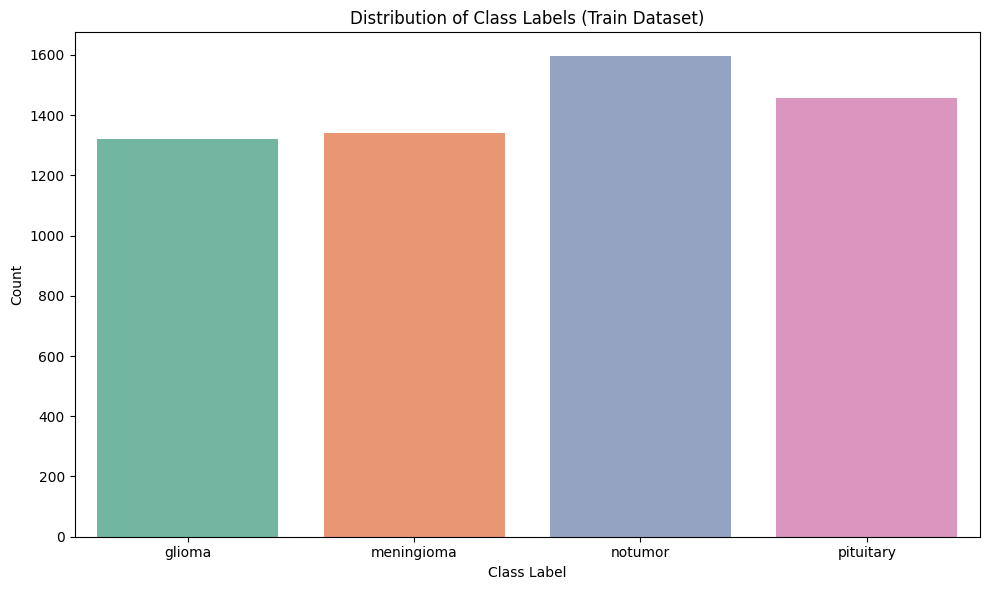

In [12]:
train_classes = [CLASS_NAMES[label_idx] for _, label_idx in train_dataset]
unique_vals, counts = np.unique(train_classes, return_counts=True)
df_dist = pd.DataFrame({"Class Label": unique_vals, "Count": counts})

plt.figure(figsize=(10, 6))
sns.barplot(data=df_dist, x="Class Label", y="Count", hue="Class Label", palette="Set2")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Distribution of Class Labels (Train Dataset)")
plt.tight_layout()
plt.show()

## 6. Transfer Learning
Transfer learning is a powerful technique in deep learning where a model pretrained on a large, general dataset is adapted for a related task. This practice improves performance while reducing the amount of training data and training time required.

Setting `param.requires_grad = False` in PyTorch freezes the model parameters (weights and biases), preventing gradient computations and updates during training. This allows parts of the model to remain unchanged while selectively training other layers.

### ResNet-18
ResNet-18 is a convolutional neural network known for its residual connections, which help training deeper networks by mitigating the vanishing gradient problem. It consists of 18 layers structured into four sequential blocks (layer1 to layer4), each containing two residual blocks. In our setup, we freeze all parameters except for the final block (layer4), which is unfrozen to allow the model to adapt deeper, more complex features specific to the image data while keeping most of the pretrained features intact.

In [13]:
class ResNet18(nn.Module):
    """
    ResNet-18 model adapted for classification with optional layer freezing.

    Attributes:
        device: The device to which the model is moved.
        model: The ResNet-18 backbone model.
    """

    def __init__(
        self,
        num_classes: int,
        freeze: bool | None = True,
        device: torch.device | str = "cpu",
    ) -> None:
        """
        Initialise ResNet18 model with transfer learning layers.

        Args:
            num_classes: Number of output classes.
            freeze: Whether to freeze early layers. Defaults to True.
            device: Device for the model (e.g., 'cpu', 'mps' or 'cuda'). Defaults to 'cpu'.
        """
        super().__init__()
        self.device = device
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=self.model.fc.in_features, out_features=num_classes),
        )

        if freeze:
            # Freeze all layers initially
            for param in self.model.parameters():  # all layers
                param.requires_grad = False
            # Unfreeze only the 4th layer by default
            for param in self.model.layer4.parameters():  # layer4
                param.requires_grad = True

        self.to(device=self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ResNet18 model.

        Args:
            x: Input tensor of shape (batch_size, channels, height, width).

        Returns:
            Output logits tensor of shape (batch_size, num_classes).
        """
        return self.model(x)

### EfficientNet B0
EfficientNet B0 is a convolutional neural network architecture optimised for both accuracy and efficiency using a compound scaling method that uniformly scales network depth, width, and resolution. Its feature extractor consists of multiple blocks arranged sequentially. In our setup, we freeze all layers except for the deepest two feature blocks (indices 6 and 7) and the final classifier head. This approach allows fine-tuning of the most specialised, high-level features as well as the classification layer, enabling the model to better capture domain-specific patterns while retaining pretrained knowledge.

In [14]:
class EfficientNetB0(nn.Module):
    """
    EfficientNet-B0 model adapted for classification with optional layer freezing.

    Attributes:
        device: The device to which the model is moved.
        model: The EfficientNet-B0 backbone model.
    """

    def __init__(
        self, num_classes: int, freeze: bool = True, device: torch.device | None = "cpu"
    ) -> None:
        """
        Initialise EfficientNetB0 model with customized classifier and freezing options.

        Args:
            num_classes: Number of output classes.
            freeze: Whether to freeze early layers. Defaults to True.
            device: Device for the model (e.g., 'cpu', 'mps' or 'cuda'). Defaults to 'cpu'.
        """
        super().__init__()
        self.device = device
        self.model = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.DEFAULT
        )
        n_features = self.model.classifier[1].in_features  # [0]: Dropout, [1]: Linear

        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=n_features, out_features=num_classes),
        )

        if freeze:
            # Freeze all layers initially
            for param in self.model.parameters():
                param.requires_grad = False
            # Unfreeze only the 2 last layers and classifier by default
            for param in self.model.features[7].parameters():  # Sequential (6)
                param.requires_grad = True
            for param in self.model.features[6].parameters():  # Sequential (7)
                param.requires_grad = True
            for param in self.model.classifier.parameters():
                param.requires_grad = True

        self.to(device=device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the EfficientNetB0 model.

        Args:
            x: Input tensor of shape (batch_size, channels, height, width).

        Returns:
            Output logits tensor of shape (batch_size, num_classes).
        """
        return self.model(x)

In [15]:
resnet18 = ResNet18(num_classes=N_CLASSES, device=DEVICE)
enb0 = EfficientNetB0(num_classes=N_CLASSES, device=DEVICE)

In [16]:
for model in [resnet18, enb0]:
    print(
        summary(
            model=model,
            input_size=(
                BATCH_SIZE,
                3,
                IMAGE_SIZE,
                IMAGE_SIZE,
            ),  # (batch_size, colour channels, height, width)
            verbose=0,
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"],
        )
    )
    print("\n")

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ResNet18 (ResNet18)                           [16, 3, 224, 224]    [16, 4]              --                   Partial
├─ResNet (model)                              [16, 3, 224, 224]    [16, 4]              --                   Partial
│    └─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   (128)                False
│    └─ReLU (relu)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
│    └─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
│    └─Sequential (layer1)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   False
│    │    └─BasicBlock (0)                    [16, 64, 56, 56]     [16, 64, 56

## 7. Evaluation Metrics
We will use the following evaluation metrics:
- `torchmetrics.Accuracy`
- `torchmetrics.F1Score`

In [17]:
accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES).to(device=DEVICE)
f1 = F1Score(task="multiclass", num_classes=N_CLASSES, average="macro").to(
    device=DEVICE
)
metrics = [accuracy, f1]

## 8. Loss Function
### Cross-Entropy Loss
Cross-Entropy Loss is a loss function used for classification problems, particularly when the model outputs probabilities using a softmax activation in the final layer. It measures the difference between the true labels and the predicted probability distribution.

For a single data point, the cross-entropy loss is defined as:

\begin{align*}
    L = - \sum^{k}_{i=1}y_{i}\log{(\hat y_{i})}
\end{align*}

where:
- $y_i$: True label for the $i$-th class. If one-hot encoded, $y_{i} = 1$ for the corrected class, $y_{i} = 0$ otherwise.
- $\hat y_i$: Predicted probability for the $i$-th class.
- $k$: Number of classes.

For a batch of $m$ data point:

\begin{align*}
    C = \dfrac{1}{m} \sum^{m}_{j=1} \left (- \sum^{k}_{i=1}y_{j, i}\log{(\hat y_{j, i})} \right)
\end{align*}

where:
- $C$: Average cross-entropy loss over the batch.
- $m$: Number of training examples (batch size).
- $k$: Number of classes.
- $y_{j, i} \in { 0, 1}$: Indicator that true class for sample $j$ corresponds to class $i$.
- $\hat y_{j, i} \in { 0, 1}$: Predicted probability for sample $j$ belonging to class $i$.

In PyTorch:
- Use `nn.CrossEntropyLoss()` directly with raw logits.
- Do not apply `Softmax()` or `LogSoftmax()` manually before the loss.
- Internally, `nn.CrossEntropyLoss() = LogSoftmax() + NegativeLogLikelihoodLoss()`. 

In [18]:
criterion = nn.CrossEntropyLoss()

## 9. Optimiser
An optimiser in neural networks is used to adjust the parameters (weights and biases) of a model during training to minimise the loss. Optimisers are essential for enabling neural networks to learn from data: without them, the model would not improve over time.

**AdamW** (a variant of the Adam optimiser) separates weight decay (L2 regularisation) from the gradient updates. This decoupling often improves a model's generalisation performance compared to the original Adam optimiser, reducing the risk of overfitting, especially in large-scale models.

**ReduceLROnPlateau** is a learning rate scheduler that monitors a specified metric (usually validation loss) and reduces the learning rate by a given factor if the metric stops improving for a certain number of epochs (`patience`). This allows the optimiser to take smaller, more precise steps when progress plateaus, often leading to better final model performance.

In [19]:
LEARNING_RATE = 1e-3
DECAY_RATE = 1e-4

# ! ===== ResNet18 =====
resnet18_optimiser = optim.AdamW(
    params=filter(lambda p: p.requires_grad, resnet18.parameters()),
    lr=LEARNING_RATE,
    weight_decay=DECAY_RATE,
)
resnet18_scheduler = ReduceLROnPlateau(
    optimizer=resnet18_optimiser, mode="min", patience=3, factor=0.5
)

# ! ===== EfficientNet B0 =====
enb0_optimiser = optim.AdamW(
    params=filter(lambda p: p.requires_grad, enb0.parameters()),
    lr=LEARNING_RATE,
    weight_decay=DECAY_RATE,
)
enb0_scheduler = ReduceLROnPlateau(
    optimizer=enb0_optimiser, mode="min", patience=3, factor=0.5
)

## 10. Training and Evaluation
1. Iterate through epochs
1. For each epoch, iterate through training batches, perform training steps, calculate the train loss and evaluation metrics per batch.
1. For each epoch, iterate through validation batches, perform validation steps, calculate the validation loss and evaluation metrics per batch.


### Training Steps
1. Zero the gradients
    - Clear the gradients from the previous iteration to prevent accumulation across batches.
1. Forward pass
    - Pass inputs through the model to obtain predictions.
1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels using a loss function.
    - Compute evaluation metrics (e.g., accuracy, F1 Score) for the current batch.
1. Backward pass
    - Compute gradients of the loss with respect to the model's parameters via backpropagation.
    - Update the parameter $\theta$ using the computed gradients, typically following:
    
    $$
        \theta \leftarrow \theta - \eta \dfrac{\partial \mathcal{L}}{\partial \theta}
    $$
    where $\eta$ is the learning rate.
1. Average training loss and evaluation metrics
    - Calculate the mean loss and metric values across all batches in the epoch.


In [20]:
def train_step(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimiser: optim.Optimizer,
    metrics: list[nn.Module],
    device: torch.device,
) -> tuple[float, list[float]]:
    """
    Perform a single epoch training step.

    Args:
        model: The neural network model to train.
        data_loader: DataLoader providing training data batches.
        criterion: Loss function.
        optimiser: Optimiser for updating model parameters.
        metrics: List of metric modules to update and compute.
        device: Device on which to perform calculations.

    Returns:
        Tuple containing average training loss and list of metric values (in %).
    """
    model.train()
    for metric in metrics:
        metric.reset()
    n_total_samples = len(data_loader.dataset)
    train_loss = 0.0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)

        # Optimiser zero grad without intervening forward pass
        optimiser.zero_grad()

        # Forward pass
        y_logits = model(inputs)

        # Calculate loss
        loss = criterion(y_logits, labels)
        train_loss += loss.item() * batch_size

        # Calculate metrics
        y_probs = torch.softmax(y_logits, dim=1)
        y_preds = torch.argmax(y_probs, dim=1)

        for metric in metrics:
            metric.update(y_preds, labels)

        # Loss backward for backpropagation (computing gradients)
        loss.backward()

        # Optimiser step to apply gradients and update parameters
        optimiser.step()

    avg_train_loss = train_loss / n_total_samples  # Average (number of samples)
    train_metric_scores = [metric.compute().item() * 100 for metric in metrics]
    return avg_train_loss, train_metric_scores

### Validation Steps
1. Forward pass
    - Set the model to evaluation mode (which disables dropout and batch normalisation and desactivates gradient tracking for safety).
    - Pass inputs through the model to obtain predictions.
1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels using a loss function.
    - Compute evaluation metrics (e.g., accuracy, F1-Score) for the current batch.
1. Average test loss and evaluation metrics
    - Calculate the mean loss and metric values across all batches in the epoch.

In [21]:
def validation_step(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    metrics: list[nn.Module],
    device: torch.device,
) -> tuple[float, list[float]]:
    """
    Perform a single epoch validation step.

    Args:
        model: The neural network model to validate.
        data_loader: DataLoader providing validation data batches.
        criterion: Loss function.
        metrics: List of metric modules to update and compute.
        device: Device on which to perform calculations.

    Returns:
        A tuple containing average validation loss and list of metric values (in %).
    """
    model.eval()
    validation_loss = 0.0
    n_total_samples = len(data_loader.dataset)
    for metric in metrics:
        metric.reset()

    with torch.inference_mode():
        for inputs, labels in data_loader:
            batch_size = inputs.size(0)
            inputs, labels = inputs.to(device), labels.to(device)

            # 1. Forward pass
            y_logits = model(inputs)

            # 2. Calculate loss
            loss = criterion(y_logits, labels)
            validation_loss += loss.item() * batch_size

            # 3. Calculate metrics
            y_probs = torch.softmax(input=y_logits, dim=1)
            y_preds = torch.argmax(y_probs, dim=1)

            for metric in metrics:
                metric.update(y_preds, labels)

    avg_val_loss = validation_loss / n_total_samples
    val_metric_scores = [metric.compute().item() * 100 for metric in metrics]
    return avg_val_loss, val_metric_scores

### Model Training and Evaluation Pipeline

In [22]:
def train_and_validate(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimiser: optim.Optimizer,
    scheduler: optim.lr_scheduler,
    metrics: list[nn.Module],
    device: torch.device,
    total_epochs: int,
) -> dict[str, list[float]]:
    """
    Run training and validation over specified epochs and tracks metrics.

    Args:
        model: The neural network model.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: Loss function.
        optimiser: Optimiser for training.
        scheduler: Learning rate scheduler.
        metrics: Metric modules to evaluate.
        device: Computation device.
        total_epochs: Number of epochs to train.

    Returns:
        Dictionary recording training and validation loss and metrics.
    """
    model.to(device)
    epochs_range = range(1, total_epochs + 1)
    best_loss = float("inf")
    # patience_counter = 0
    best_epoch = 0
    model_name = model.__class__.__name__.lower()

    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
    }

    start_time = time.time()

    for epoch in epochs_range:
        train_loss, train_metrics = train_step(
            model=model,
            data_loader=train_loader,
            criterion=criterion,
            optimiser=optimiser,
            metrics=metrics,
            device=device,
        )
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_metrics[0])
        history["train_f1"].append(train_metrics[1])

        val_loss, val_metrics = validation_step(
            model=model,
            data_loader=val_loader,
            criterion=criterion,
            metrics=metrics,
            device=device,
        )
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_metrics[0])
        history["val_f1"].append(val_metrics[1])

        scheduler.step(val_loss)  # Update learning rate based on validation loss

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(obj=model.state_dict(), f=f"{model_name}_best.pth")
            # patience_counter = 0
            best_epoch = epoch
        # else: # Early Stopping
        #     patience_counter += 1
        #     if patience_counter >= 5:
        #         print(f"Early stopping at epoch {epoch}")
        #         break

        print(f"Epoch [{epoch}/{total_epochs}]\n{'=' * 60}")
        print(
            f"{'Train Loss:':<12}{train_loss:>6.4f} | {'Train Accuracy:':<15}{train_metrics[0]:>6.2f}% | {'Train F1:':<10}{train_metrics[1]:>6.2f}%"
        )
        print(
            f"{'Val Loss:':<12}{val_loss:>6.4f} | {'Val Accuracy:':<15}{val_metrics[0]:>6.2f}% | {'Val F1:':<10}{val_metrics[1]:>6.2f}%\n"
        )

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training and validation completed in {elapsed_time:.2f} seconds.\n")
    print(f"The best-performing model was saved at epoch: {best_epoch}")
    return history

In [23]:
EPOCHS = 20
EPOCH_RANGE = range(1, EPOCHS + 1)
MODEL_NAME_RESNET18 = "ResNet18"
MODEL_NAME_ENB0 = "EfficientNet B0"

print(f"Training {MODEL_NAME_RESNET18}...")
resnet18_history = train_and_validate(
    model=resnet18,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimiser=resnet18_optimiser,
    scheduler=resnet18_scheduler,
    metrics=metrics,
    device=DEVICE,
    total_epochs=EPOCHS,
)

print(f"Training {MODEL_NAME_ENB0}...")
enb0_history = train_and_validate(
    model=enb0,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimiser=enb0_optimiser,
    scheduler=enb0_scheduler,
    metrics=metrics,
    device=DEVICE,
    total_epochs=EPOCHS,
)

Training ResNet18...
Epoch [1/20]
Train Loss: 0.3816 | Train Accuracy: 86.68% | Train F1:  86.29%
Val Loss:   0.2286 | Val Accuracy:   91.45% | Val F1:    91.13%

Epoch [2/20]
Train Loss: 0.2273 | Train Accuracy: 91.84% | Train F1:  91.55%
Val Loss:   0.1847 | Val Accuracy:   93.74% | Val F1:    93.32%

Epoch [3/20]
Train Loss: 0.1905 | Train Accuracy: 93.42% | Train F1:  93.20%
Val Loss:   0.1494 | Val Accuracy:   94.20% | Val F1:    93.94%

Epoch [4/20]
Train Loss: 0.1474 | Train Accuracy: 95.08% | Train F1:  94.91%
Val Loss:   0.1242 | Val Accuracy:   94.66% | Val F1:    94.27%

Epoch [5/20]
Train Loss: 0.1308 | Train Accuracy: 95.33% | Train F1:  95.17%
Val Loss:   0.0753 | Val Accuracy:   97.25% | Val F1:    97.06%

Epoch [6/20]
Train Loss: 0.1080 | Train Accuracy: 96.50% | Train F1:  96.37%
Val Loss:   0.0941 | Val Accuracy:   96.64% | Val F1:    96.49%

Epoch [7/20]
Train Loss: 0.1011 | Train Accuracy: 96.53% | Train F1:  96.40%
Val Loss:   0.1024 | Val Accuracy:   95.42% | Val 

## 11. Results
### Overall Performance

In [24]:
resnet18_train_metrics = {
    "Loss": resnet18_history["train_loss"],
    "Accuracy": resnet18_history["train_acc"],
    "F1 Score": resnet18_history["train_f1"],
}

resnet18_val_metrics = {
    "Loss": resnet18_history["val_loss"],
    "Accuracy": resnet18_history["val_acc"],
    "F1 Score": resnet18_history["val_f1"],
}

enb0_train_metrics = {
    "Loss": enb0_history["train_loss"],
    "Accuracy": enb0_history["train_acc"],
    "F1 Score": enb0_history["train_f1"],
}

enb0_val_metrics = {
    "Loss": enb0_history["val_loss"],
    "Accuracy": enb0_history["val_acc"],
    "F1 Score": enb0_history["val_f1"],
}

In [25]:
def plot_results(
    epochs_range: range,
    model_name: str,
    train_metrics: dict[str, list[float]],
    val_metrics: dict[str, list[float]],
) -> None:
    """
    Plots training and validation metrics per epoch for comparison.

    Args:
        epochs_range: Range of epoch numbers.
        model_name: Name of the model for title annotation.
        train_metrics: Training metric values.
        val_metrics: Validation metric values.
    """
    metric_names = list(train_metrics.keys())
    n_metrics = len(metric_names)
    fig, axes = plt.subplots(nrows=1, ncols=n_metrics, figsize=(16, 6))
    axes = axes.flatten()
    for i, metric_name in enumerate(metric_names):
        ax = axes[i]
        ax.plot(
            epochs_range,
            train_metrics[metric_name],
            label=f"Train {metric_name}",
        )  # Train metric
        ax.plot(
            epochs_range,
            val_metrics[metric_name],
            label=f"Validation {metric_name}",
        )  # Validation metric
        ax.set_title(f"{model_name}: {metric_name} Over Epochs", fontsize=12)
        ax.legend()
        ax.set_xlabel("Epoch")
        if metric_name == "Loss":
            ax.set_ylabel("Loss")
        else:
            ax.set_ylabel(f"f{metric_name} (%)")

    plt.tight_layout()
    plt.show()


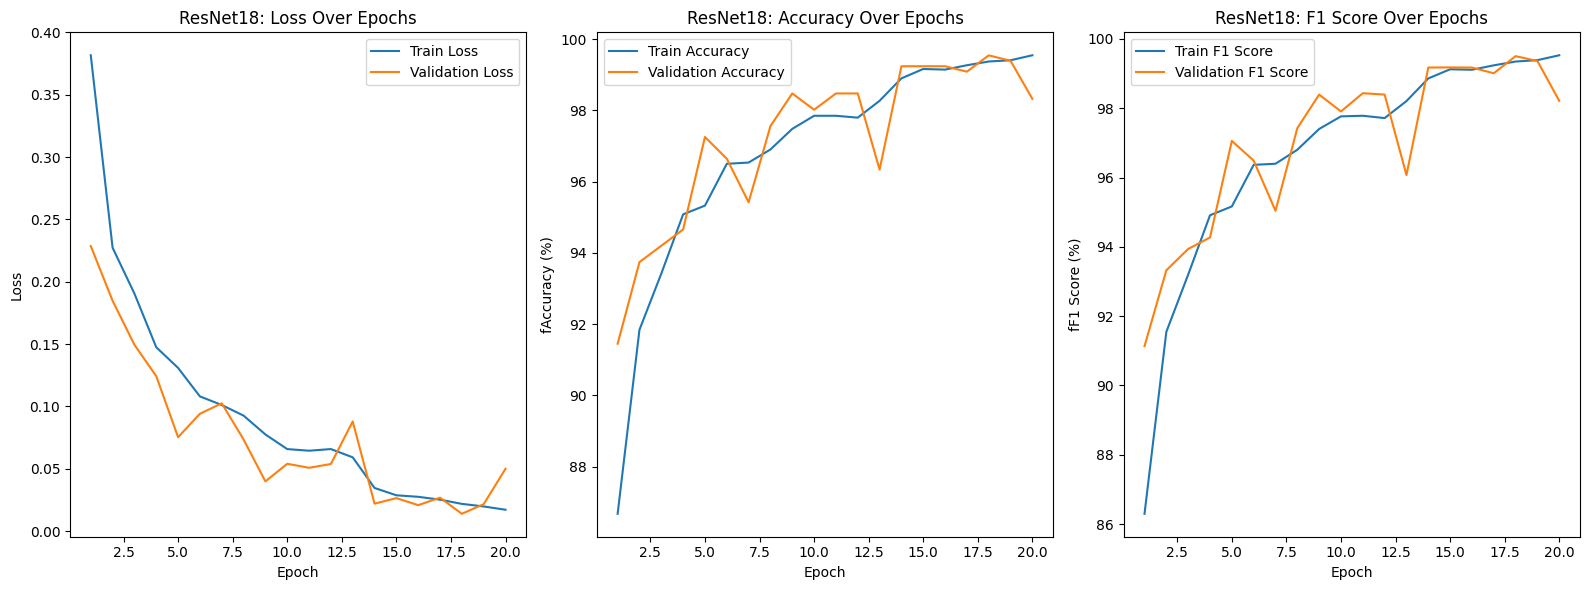

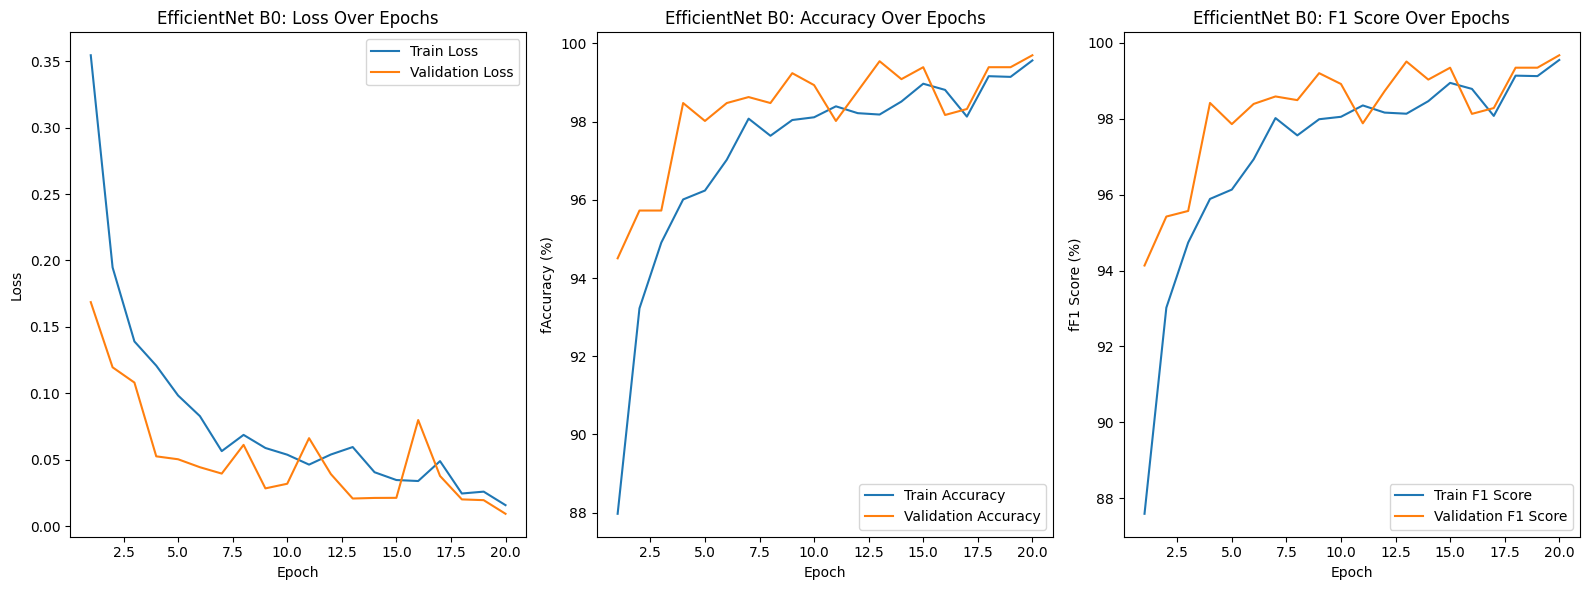

In [26]:
plot_results(
    epochs_range=EPOCH_RANGE,
    model_name=MODEL_NAME_RESNET18,
    train_metrics=resnet18_train_metrics,
    val_metrics=resnet18_val_metrics,
)
plot_results(
    epochs_range=EPOCH_RANGE,
    model_name=MODEL_NAME_ENB0,
    train_metrics=enb0_train_metrics,
    val_metrics=enb0_val_metrics,
)

### Classifications

In [27]:
def make_all_predictions(
    model: nn.Module,
    model_name: str,
    data_loader: DataLoader,
    criterion: nn.Module,
    metrics: list[nn.Module],
    device: torch.device,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Make predictions over an entire dataset and calculates metrics.

    Args:
        model: Trained model to use for predictions.
        model_name: Model name for printing outputs.
        data_loader: DataLoader for dataset to predict on.
        criterion: Loss function to compute loss.
        metrics: Metric modules to compute during prediction.
        device: Device for computation.

    Returns:
        A tuple containing concatenated predicted labels and true labels.
    """
    model_file_name = model.__class__.__name__.lower()
    model.load_state_dict(
        state_dict=torch.load(f=f"{model_file_name}_best.pth", map_location=device),
    )
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    n_total_samples = len(data_loader.dataset)
    for metric in metrics:
        metric.reset()

    with torch.inference_mode():
        for inputs, labels in data_loader:
            batch_size = inputs.size(0)
            inputs, labels = inputs.to(device), labels.to(device)

            # 1. Forward pass
            y_logits = model(inputs)
            y_probs = torch.softmax(y_logits, dim=1)
            y_preds = torch.argmax(y_probs, dim=1)

            all_preds.append(y_preds.cpu())
            all_labels.append(labels.cpu())

            # 2. Calculate test loss
            test_loss += criterion(y_logits, labels).item() * batch_size

            # 3. Calculate test metrics
            for metric in metrics:
                metric.update(y_preds, labels)

    test_loss /= n_total_samples
    test_acc = metrics[0].compute().item() * 100
    test_f1 = metrics[1].compute().item() * 100

    print(f"{model_name}\n{'=' * 60}")
    print(
        f"{'Test Loss:':<12}{test_loss:>6.4f} | {'Test Accuracy:':<15}{test_acc:>6.2f}% | {'Test F1:':<10}{test_f1:>6.2f}%\n"
    )
    all_preds_tensor = torch.cat(all_preds)
    all_labels_tensor = torch.cat(all_labels)
    return all_preds_tensor, all_labels_tensor

Creating a new model instance before loading saved weights ensures the model to start from a clean, well-defined architecture without any unintended changes or leftover states from previous training runs (such as optimiser internal states, hooks, or temporarily stored variables). This practice helps avoid bugs and inconsistencies during evaluation.

Subsequently, the `make_all_predictions()` function uses this freshly loaded, optimised model (with trained weights) to generate predictions reliably for the dataset, ensuring that the evaluation reflects the learned parameters from training.

In [28]:
resnet18 = ResNet18(num_classes=N_CLASSES, freeze=False, device=DEVICE)

all_preds_resnet18, all_labels_resnet18 = make_all_predictions(
    model=resnet18,
    model_name=MODEL_NAME_RESNET18,
    data_loader=test_loader,
    criterion=criterion,
    metrics=metrics,
    device=DEVICE,
)


enb0 = EfficientNetB0(num_classes=N_CLASSES, freeze=False, device=DEVICE)

all_preds_enb0, all_labels_enb0 = make_all_predictions(
    model=enb0,
    model_name=MODEL_NAME_ENB0,
    data_loader=test_loader,
    criterion=criterion,
    metrics=metrics,
    device=DEVICE,
)

ResNet18
Test Loss:  0.0216 | Test Accuracy:  99.39% | Test F1:   99.34%

EfficientNet B0
Test Loss:  0.0184 | Test Accuracy:  99.24% | Test F1:   99.18%



In [29]:
print(f"{MODEL_NAME_RESNET18}\n{'=' * 60}")
print(classification_report(y_true=all_labels_resnet18, y_pred=all_preds_resnet18))

print(f"\n{MODEL_NAME_ENB0}\n{'=' * 60}")
print(classification_report(y_true=all_labels_enb0, y_pred=all_preds_enb0))

ResNet18
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       150
           1       0.98      0.99      0.99       153
           2       1.00      1.00      1.00       203
           3       1.00      1.00      1.00       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656


EfficientNet B0
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       150
           1       0.97      0.99      0.98       153
           2       1.00      1.00      1.00       203
           3       0.99      0.99      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



### Missclassifications

In [30]:
def print_missclassifications(
    all_preds: torch.Tensor,
    all_labels: torch.Tensor,
    model_name: str,
) -> None:
    """
    Prints the count and rate of misclassified samples.

    Args:
        all_preds: Tensor of predicted labels.
        all_labels: Tensor of true labels.
        model_name: Model name for printing context.
    """
    missclassified = all_preds != all_labels
    n_missclassified = int(missclassified.sum())
    missclassified_rate = 100 * n_missclassified / len(all_labels)
    print(f"{model_name}\n{'=' * 60}")
    print(
        f"Number of failed predictions: {n_missclassified}/{len(all_labels)} ({missclassified_rate:.2f}%)\n"
    )

In [31]:
print_missclassifications(
    all_preds=all_preds_resnet18,
    all_labels=all_labels_resnet18,
    model_name=MODEL_NAME_RESNET18,
)

print_missclassifications(
    all_preds=all_preds_enb0,
    all_labels=all_labels_enb0,
    model_name=MODEL_NAME_ENB0,
)

ResNet18
Number of failed predictions: 4/656 (0.61%)

EfficientNet B0
Number of failed predictions: 5/656 (0.76%)



### Confusion Matrix

In [32]:
def plot_confusion_matrix(
    cm: NDArray[np.int64] | torch.Tensor,
    class_names: list[str],
    model_name: str,
) -> None:
    """
    Plot a confusion matrix using seaborn heatmap.

    Args:
        cm: Confusion matrix data.
        class_names: List of class names for axes.
        model_name: Model name for plot title.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        data=cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{model_name}: Confusion Matrix")
    plt.show()

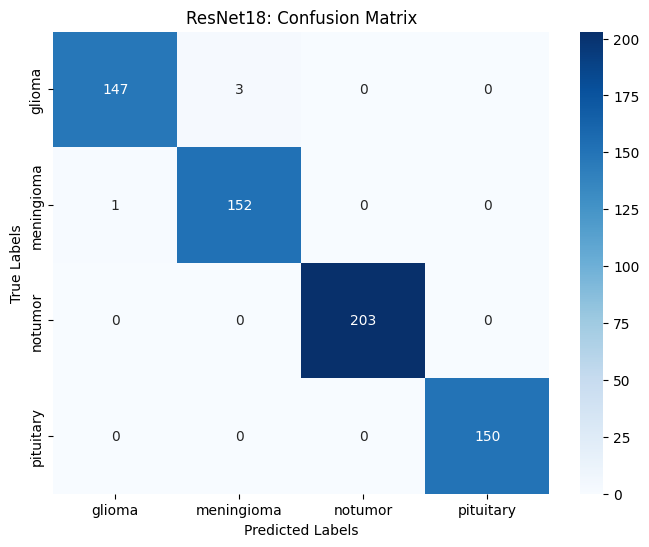

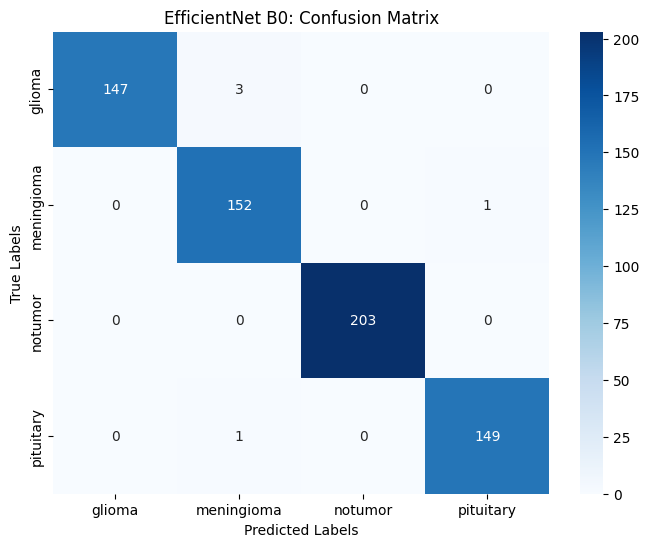

In [33]:
cm_resnet18 = confusion_matrix(
    y_true=all_labels_resnet18,
    y_pred=all_preds_resnet18,
)

cm_enb0 = confusion_matrix(
    y_true=all_labels_enb0,
    y_pred=all_preds_enb0,
)


plot_confusion_matrix(
    cm=cm_resnet18,
    class_names=CLASS_NAMES,
    model_name=MODEL_NAME_RESNET18,
)

plot_confusion_matrix(
    cm=cm_enb0,
    class_names=CLASS_NAMES,
    model_name=MODEL_NAME_ENB0,
)

### Observations
The fine-tuned ResNet-18 and EfficientNet B0 models both demonstrated remarkably high performance on the test dataset.
The ResNet-18 model achieved an accuracy of 99.39% and an F1 score of 99.34%, while the EfficientNet B0 model provided an accuracy of 99.24% with an F1 score of 99.18%.

## 12. Vision Transformer (ViT)
The Vision Transformer (ViT) is a model architecture adapted from transformer models originally developed for natural language processing (NLP), specifically tailored for computer vision tasks. ViT treats an image as a sequence of fixed-size patches, analogous to tokens in text processing. These image patches are linearly embedded and then processed through transformer encoder layers, which utilise self-attention mechanisms to capture relationships between different parts of the image.

The advantages of transformers, including global context understanding, parallelisability, and high performance with large datasets, have made the Vision Transformer particularly successful not only in text processing but also in computer vision.

### Converting Image Data for ViT
The Hugging Face `Trainer` excepts datasets to return dictionaries rather than tuples. For image classification, it needs to be:
```
{
    'pixel_values': tensor_of_image,
    'labels: label_integer
}
```

In [34]:
warnings.filterwarnings(
    "ignore", message="'pin_memory' argument is set as true but not supported on MPS"
)

In [35]:
class TransformerDatasetWrapper(Dataset):
    """
    Wrapper around a dataset to output inputs as dictionary with 'pixel_values' and 'labels',
    compatible with Hugging Face Trainer.

    Attributes:
        dataset: Original dataset.
    """

    def __init__(self, dataset: Dataset) -> None:
        """
        Initialise with original dataset.

        Args:
            dataset: The dataset to wrap.
        """
        self.dataset = dataset

    def __len__(self) -> int:
        """
        Return the number of samples.

        Returns:
            int: Dataset length.
        """
        return len(self.dataset)

    def __getitem__(self, index: int) -> dict[str, torch.Tensor | int]:
        """
        Return a sample as a dictionary with keys 'pixel_values' and 'labels'.

        Args:
            index: Sample index.

        Returns:
            Sample dictionary.
        """
        image, label = self.dataset[index]
        return {
            "pixel_values": image,
            "labels": label,
        }

In [36]:
train_dataset_vit = TransformerDatasetWrapper(dataset=train_dataset)
val_dataset_vit = TransformerDatasetWrapper(dataset=val_dataset)
test_dataset_vit = TransformerDatasetWrapper(dataset=test_dataset)

train_dataset.class_to_idx = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [37]:
MY_MODEL_PATH = "./my_finetuned_model"
RANDOM_SEED = 42
N_EPOCHS_VIT = 5
LABEL_2_ID = {"GLIOMA": 0, "MENINGIOMA": 1, "NO TUMOUR": 2, "PITUITARY": 3}
ID_2_LABEL = {0: "GLIOMA", 1: "MENINGIOMA", 2: "NO TUMOUR", 3: "PITUITARY"}

### Loading Pre-Trained Model

In [38]:
from transformers import ViTForImageClassification, ViTImageProcessor

VIT_MODEL_NAME = "google/vit-base-patch16-224-in21k"
VIT_MODEL = ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path=VIT_MODEL_NAME,
    id2label=ID_2_LABEL,
    label2id=LABEL_2_ID,
)
VIT_PROCESSOR = ViTImageProcessor.from_pretrained(VIT_MODEL_NAME)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training Arguments
The following code configures the training arguments for fine-tuning a Transformer model using Hugging Face's `Trainer` API.

In [39]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    report_to="none",
    eval_strategy="epoch",
    learning_rate=2e-5,
    logging_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=N_EPOCHS_VIT,
    weight_decay=0.01,
    seed=RANDOM_SEED,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

### Evaluation Metrics for ViT
The overall performance of the fine‑tuned model will be evaluated using two metrics: accuracy and the F1‑score.

In [40]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")


def compute_metrics(
    eval_pred: tuple[NDArray[np.float32], NDArray[np.int64]],
) -> dict[str, float]:
    """
    Compute accuracy and weighted F1 score metrics suitable for Hugging Face Trainer evaluation.

    Args:
        eval_pred: Tuple with model logits and true labels.

    Returns:
        Dictionary with "accuracy" and "f1" metric scores.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(
        predictions=predictions, references=labels, average="weighted"
    )
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}


### Fine-Tuning Transformer Model

In [41]:
from transformers import Trainer

trainer = Trainer(
    model=VIT_MODEL,
    args=training_args,
    train_dataset=train_dataset_vit,
    eval_dataset=val_dataset_vit,
    compute_metrics=compute_metrics,
    processing_class=VIT_PROCESSOR,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.262900,0.194749,0.954198,0.954084
2,0.133700,0.113061,0.972519,0.972541
3,0.103400,0.119790,0.969466,0.969596
4,0.060700,0.051862,0.992366,0.992371
5,0.051800,0.040813,0.993893,0.993898


TrainOutput(global_step=1785, training_loss=0.16801443901382573, metrics={'train_runtime': 4850.4381, 'train_samples_per_second': 5.888, 'train_steps_per_second': 0.368, 'total_flos': 2.2132108953000346e+18, 'train_loss': 0.16801443901382573, 'epoch': 5.0})

In [42]:
trainer.save_model(output_dir=MY_MODEL_PATH)

### Predictions with Fine-Tuned Model
After five epochs of training, the fine-tuned ViT model achieved 99.38% accuracy and 99.38% F1 score on the validation dataset. The `.evaluate()` function from the Hugging Face Trainer class allows us to generate evaluation metrics on a test dataset once the training process is complete.

In [43]:
output = trainer.evaluate(eval_dataset=test_dataset_vit)
print(output)

{'eval_loss': 0.056278664618730545, 'eval_accuracy': 0.9908536585365854, 'eval_f1': 0.9908278924592554, 'eval_runtime': 33.6199, 'eval_samples_per_second': 19.512, 'eval_steps_per_second': 1.22, 'epoch': 5.0}


Although the performance on the test dataset is slightly lower than that on the validation dataset, an accuracy of 99.08% and an F1 score of 99.08% remain strong results, particularly given that the model employed was a base Vision Transformer (ViT) architecture designed for general-purpose computer vision tasks.

## 13. References

1. Ahmed Yassin. (2024). Medium. *Adam vs. AdamW: Understanding Weight Decay and Its Impact on Model Performance*.<br>
https://yassin01.medium.com/adam-vs-adamw-understanding-weight-decay-and-its-impact-on-model-performance-b7414f0af8a1

1. BryanWBear. (2020). GitHub Issues. *"No log" when training RobertaForSequenceClassification using Trainer #8910*.
https://github.com/huggingface/transformers/issues/8910

1. Hugging Face. (n.d.). *Vision Transformer (ViT)*.<br>
https://huggingface.co/docs/transformers/en/model_doc/vit

1. Kurtis Pykes. (2024). DataCamp.  *AdamW Optimizer in PyTorch Tutorial*.<br>
https://www.datacamp.com/tutorial/adamw-optimizer-in-pytorch

1. Masoud Nickparvar. (2021). Kaggle. *Brain Tumor MRI Dataset*.<br>
https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

1. Milad Farzalizadeh. (2023). Kaggle. *Brain Tumor Detection | Vision Transformer 99% 🚀*.<br>
https://www.kaggle.com/code/miladfa7/brain-tumor-detection-vision-transformer-99

1. PyTorch Docs. (n.d.). *AdamW*. <br>
https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html

1. PyTorch Forums. (2021). *[Discussion] Why normalise according to ImageNet mean and std dev for transfer learning?*<br>
https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

1. Sovit Ranjan Rath. (2022). DebuggerCafe. *Brain MRI Classification using PyTorch EfficientNetB0*.<br>
https://debuggercafe.com/brain-mri-classification-using-pytorch-efficientnetb0/

1. Youssef Elebiary. (2025). Kaggle. *Brain Tumor MRI Classification - 99.4% Accuracy*.<br>
https://www.kaggle.com/code/youssefelebiary/brain-tumor-mri-classification-99-4-accuracy